# Практическая работа №6. Регрессионный анализ

## Цели:
- знакомство с теоретическими основами регрессионного анализа;
- формирование навыков применения регрессионного анализа для решения задачи восстановления функциональных зависимостей с помощью языка программирования Python.
## Задачи:
1. предварительная обработка исходных данных;
2. обучение базовых регрессионных моделей;
3. подбор оптимальных параметров регрессионных моделей;
4. оценка качества построенных моделей на валидационной/тестовой выборке.
## Исходные данные:
<a href="https://www.kaggle.com/c/krasnoyarks-flat/overview">Стоимость квартиры в г. Красноярск</a>

## (#1) Импорты

In [96]:
# a b c d e f g h i j k l m n o p q r s t u v w x y z
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import (GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor, VotingRegressor)
from sklearn.linear_model import (LarsCV, Lasso, Ridge, ElasticNet, BayesianRidge, LassoCV, RidgeCV, ElasticNetCV, TweedieRegressor, LinearRegression)
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

## (#2) Загрузка данных

In [49]:
train_df = pd.read_csv("krasnoyarks-flat/train.csv")
y_train = train_df["Цена"].values
test_df = pd.read_csv("krasnoyarks-flat/test.csv")

In [50]:
test_copy = test_df.copy()

def create_submission(y_pred, algorithm_name):
    submission = test_copy.copy()
    submission["Цена"] = y_pred
    submission.set_index("id",inplace=True)
    submission[["Цена"]].to_csv(f"results//{algorithm_name}.csv")

## (#3) Обзор признаков

In [51]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         808 non-null    int64  
 1   Количество.комнат          808 non-null    int64  
 2   Студия                     808 non-null    int64  
 3   Общая.площадь              808 non-null    float64
 4   Этаж                       808 non-null    int64  
 5   Этажей.в.доме              808 non-null    int64  
 6   Парковка                   808 non-null    int64  
 7   Без.ремонта                808 non-null    int64  
 8   Дизайнерский               808 non-null    int64  
 9   Евроремонт                 808 non-null    int64  
 10  Косметический              808 non-null    int64  
 11  Балкон                     808 non-null    int64  
 12  Лоджия                     808 non-null    int64  
 13  Совмещенный.санузел        808 non-null    int64  

In [52]:
train_df.sample(5)

,id,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Евроремонт,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
117,1209,3,0,64.3,4,9,0,0,0,0,...,43,11,1,19,2,26,9,19,31,3800000.0
135,303,4,0,112.0,9,18,0,0,0,0,...,12,6,0,6,2,18,9,7,21,6500000.0
555,69,1,0,37.0,1,9,0,0,0,0,...,27,6,0,21,6,11,11,25,21,2150000.0
221,658,1,0,31.0,3,5,0,0,0,0,...,2,1,0,3,5,5,1,1,4,1600000.0
535,1525,3,0,78.0,4,9,0,1,0,0,...,13,5,1,6,5,12,9,1,15,3400000.0


### Данные без пропусков.

## (#4) Визуализация

<AxesSubplot:>

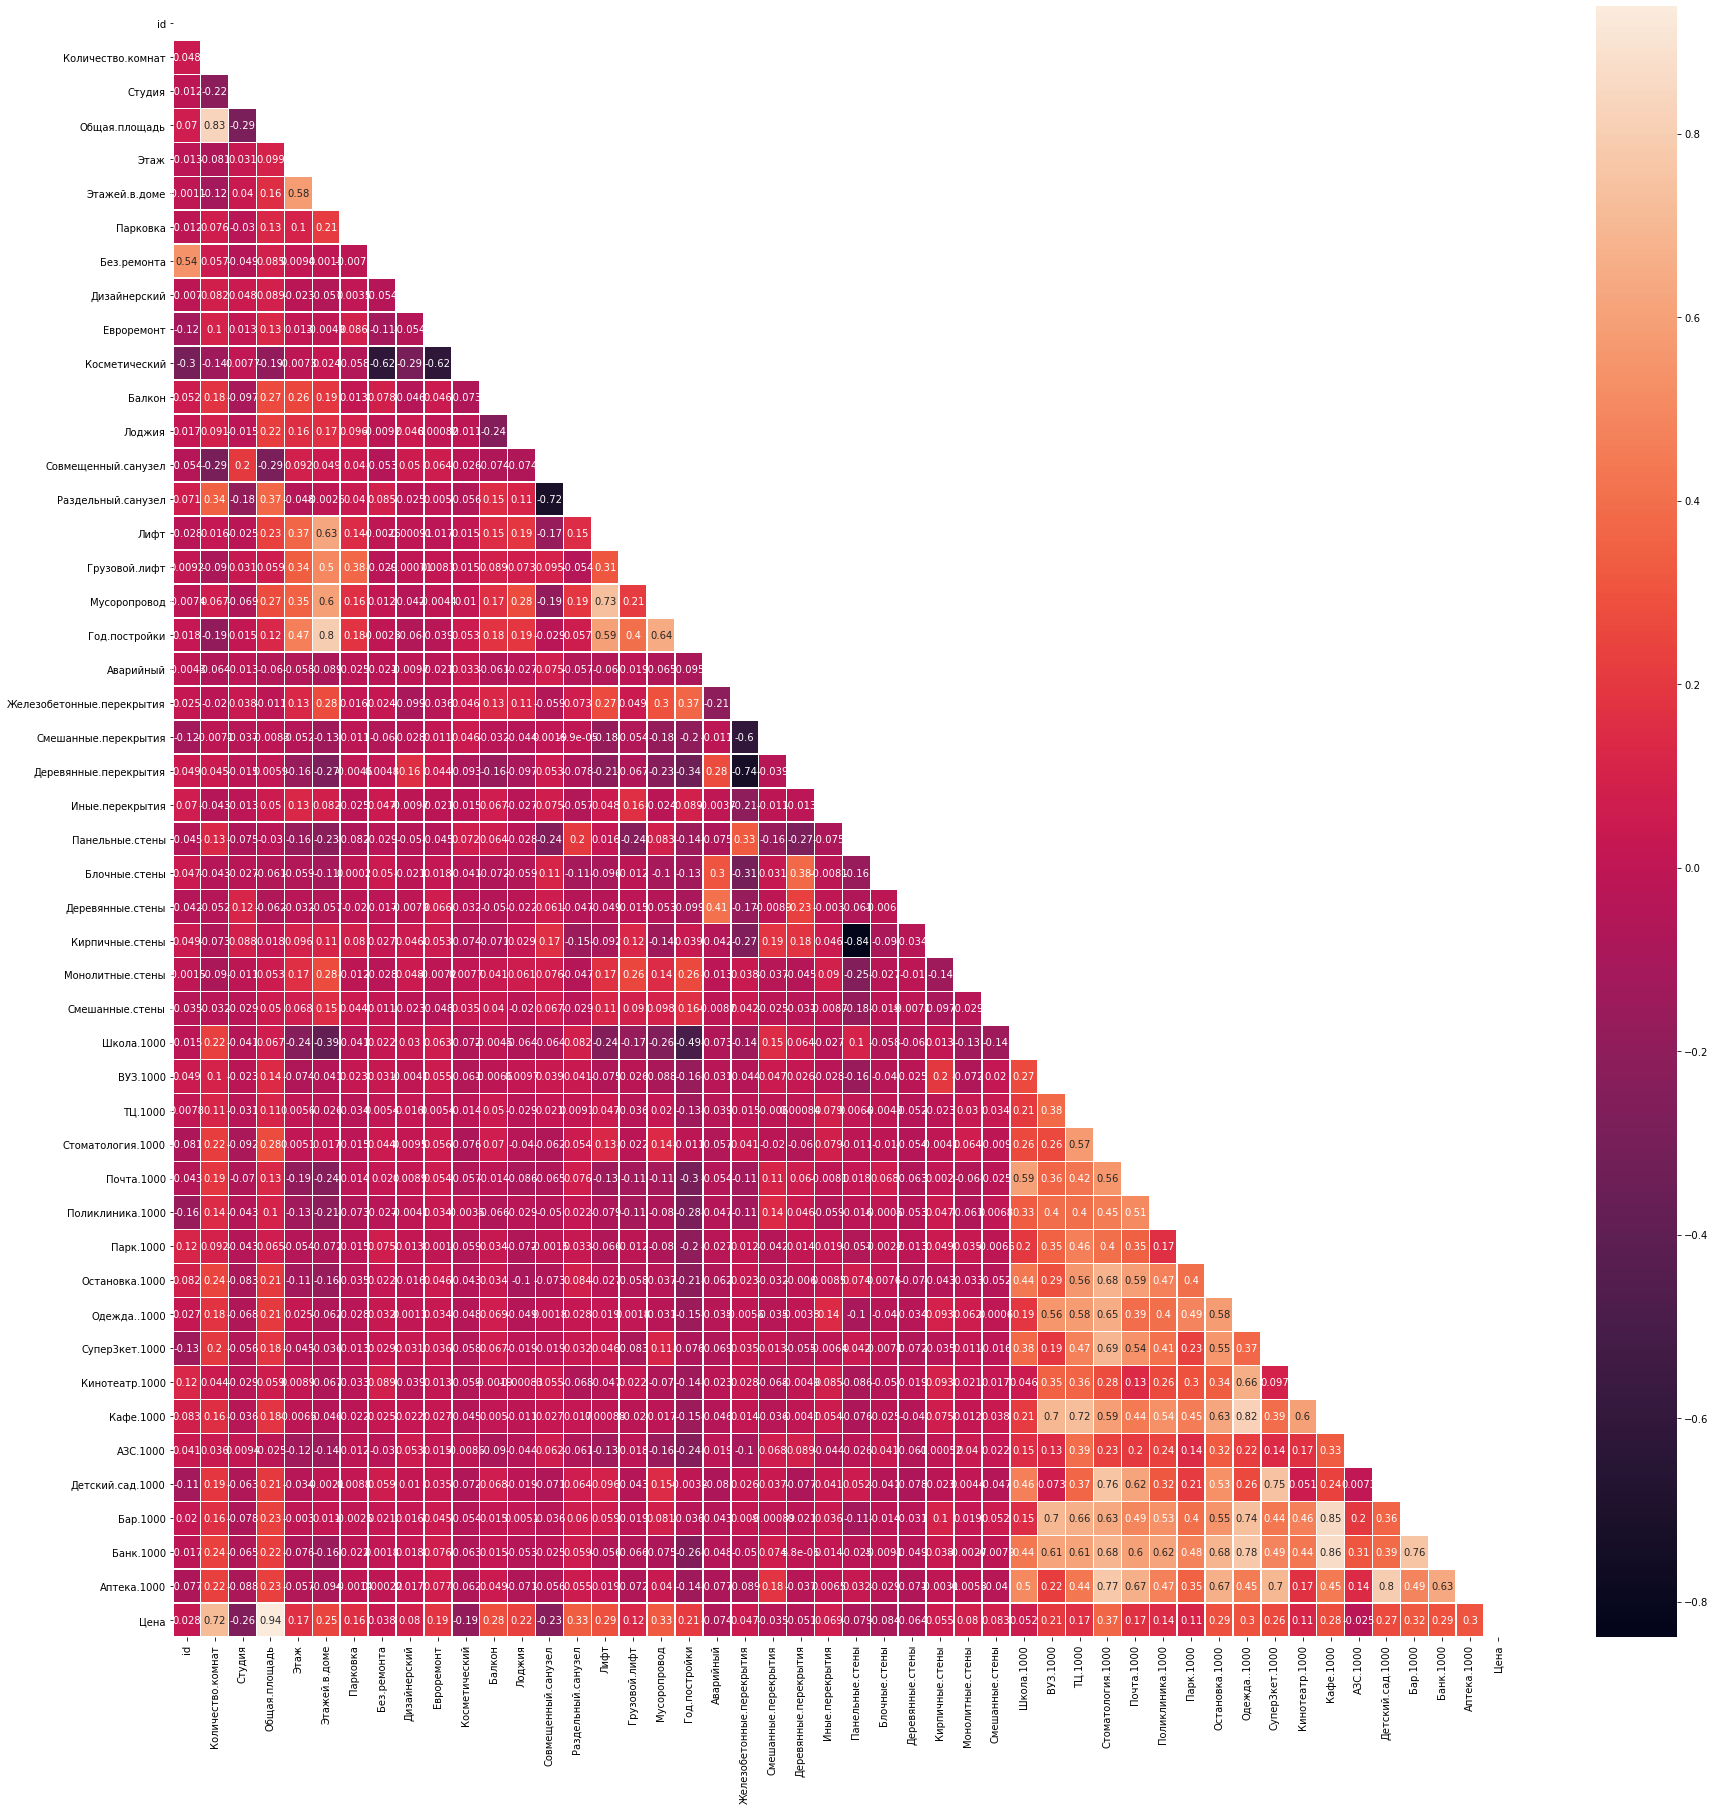

In [53]:
plt.figure(figsize=(30, 30))

corr_matrix = train_df.corr()
mask = np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, mask=mask)

In [54]:
# Оставили те столбцы, которые более-менее коррелируют с целевой переменной
correlating = ["Цена", "Количество.комнат", "Студия", "Общая.площадь", "Этаж", "Этажей.в.доме", "Парковка", "Евроремонт", "Косметический", 
               "Балкон", "Лоджия", "Раздельный.санузел", "Лифт", "Грузовой лифт", "Мусоропровод", "Год.постройки", "ВУЗ.1000", "Стоматология.1000", 
               "Остановка.1000", "Одежда..1000", "Супер3кет.1000", "Кафе.1000", "Детский.сад.1000", "Бар.1000", "Банк.1000", "Аптека.1000"]
discarded = [col for col in train_df.columns if col not in correlating]

train_df = train_df.drop(columns=discarded)
test_df = test_df.drop(columns=discarded)

<AxesSubplot:>

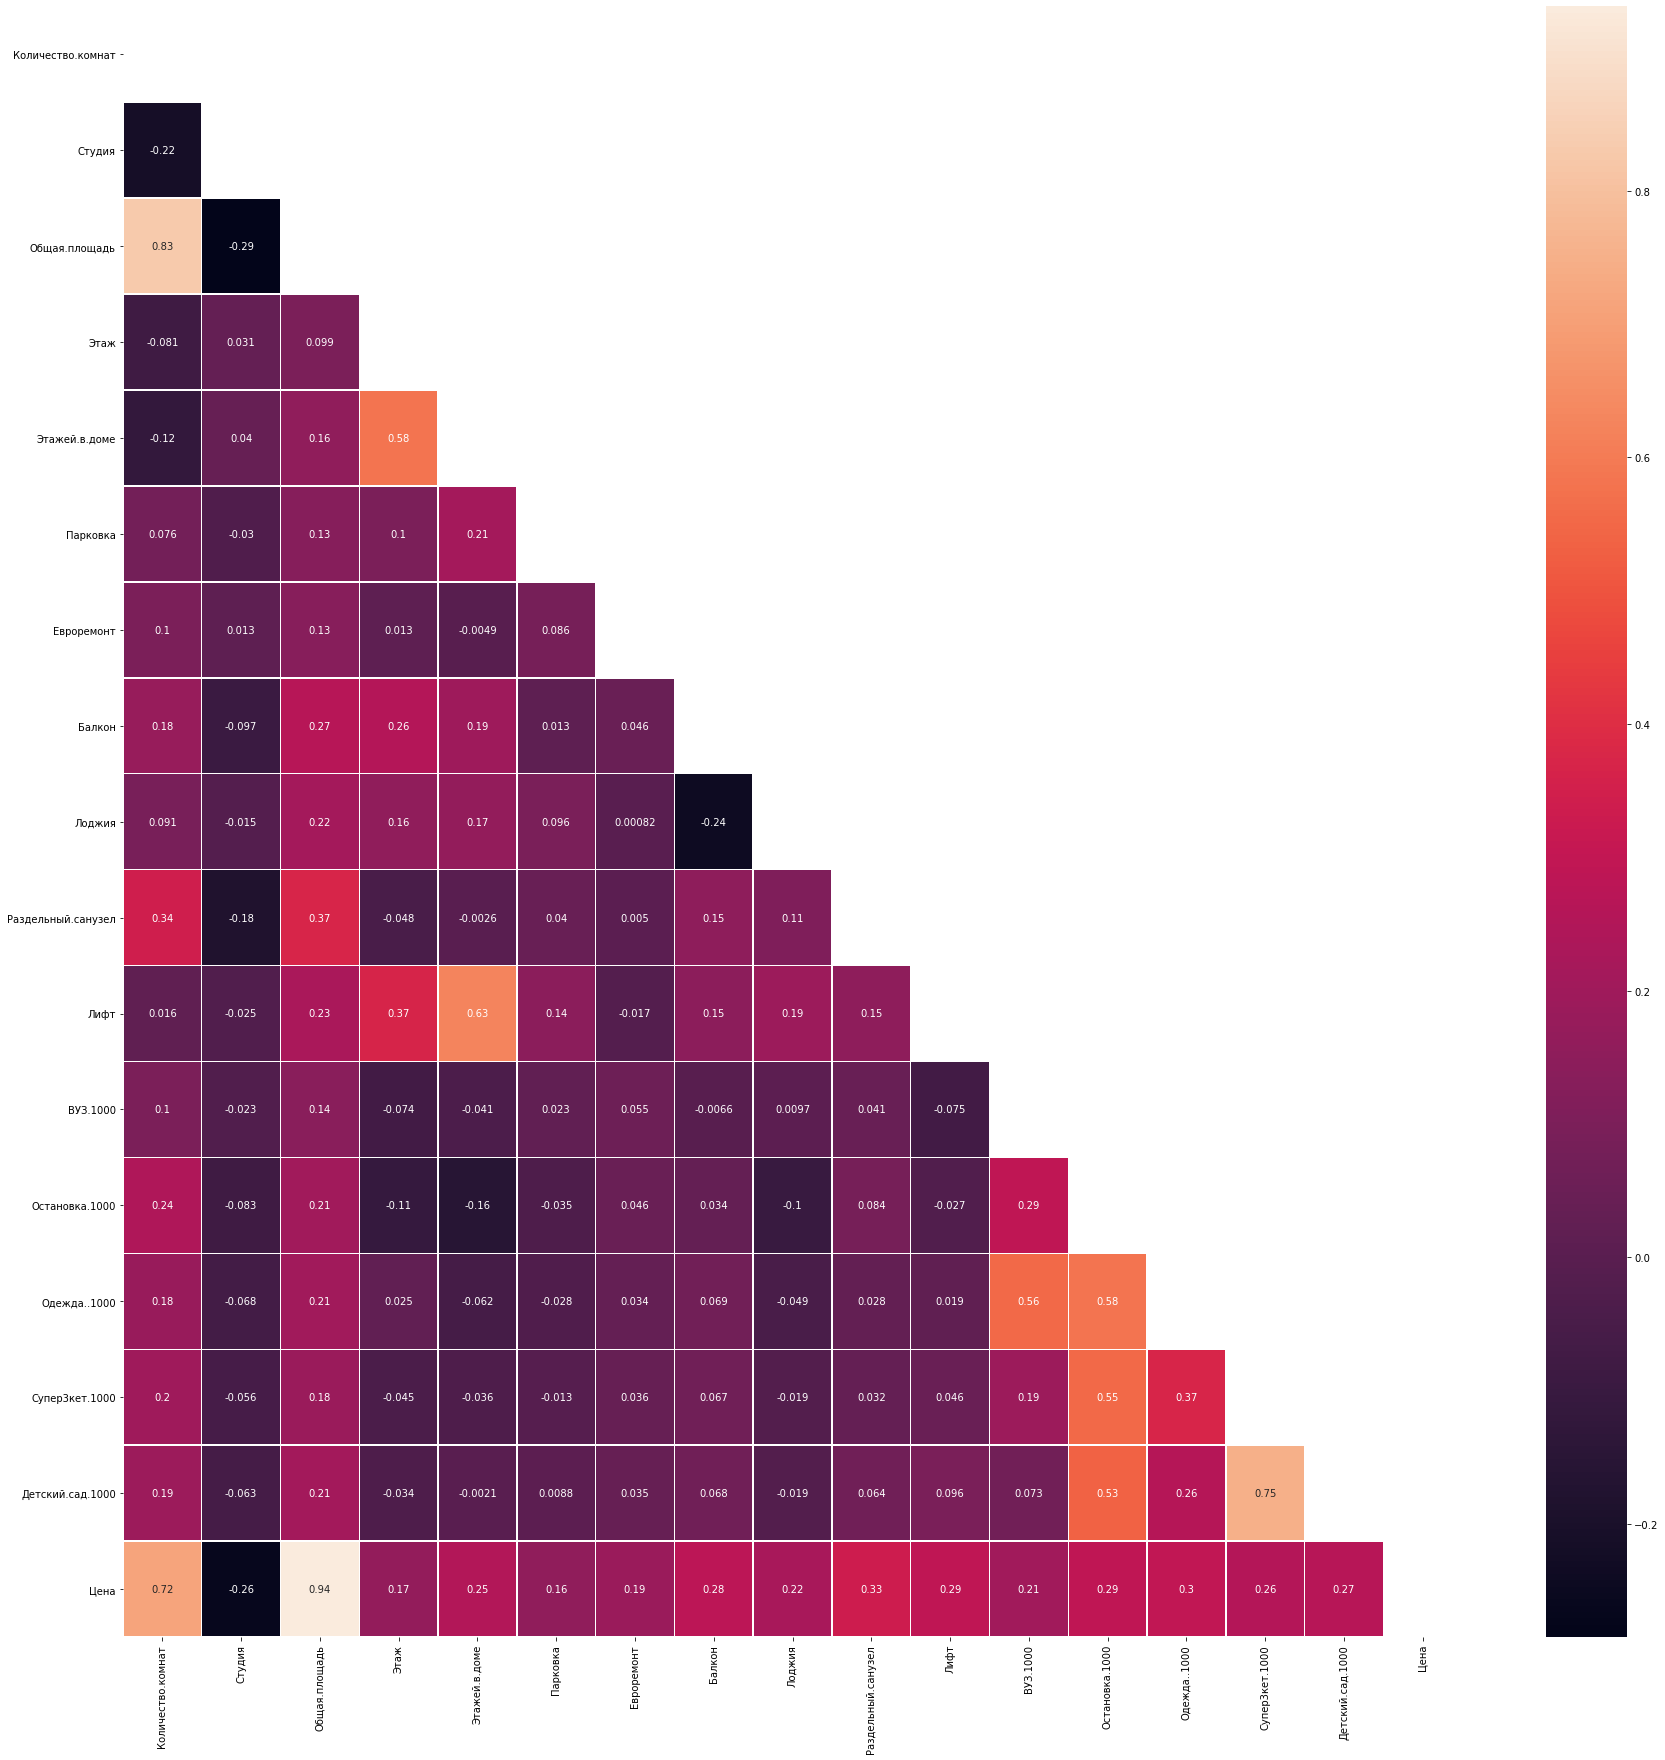

In [60]:
plt.figure(figsize=(30, 30))

corr_matrix = train_df.corr()
mask = np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, mask=mask)

In [59]:
# Убираем те, которые сильно коррелируют друг с другом
# Это итерационный процесс
discarded = ["Косметический", "Мусоропровод", "Кафе.1000", "Бар.1000", "Банк.1000", "Аптека.1000", "Стоматология.1000", "Год.постройки"]

train_df = train_df.drop(columns=discarded, errors="ignore")
test_df = test_df.drop(columns=discarded, errors="ignore")

## (#7) Построение моделей

In [100]:
x_train = train_df.drop(columns=['Цена'])
x_test = test_df

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

class_models = [Lasso, Ridge, ElasticNet, BayesianRidge, GradientBoostingRegressor, BaggingRegressor, 
               AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor, LassoCV, ElasticNetCV, RidgeCV, 
               TweedieRegressor, LarsCV, BaggingRegressor, LinearRegression]

for class_model in class_models:
    model_name = class_model.__name__
    model = class_model()
    result = cross_validate(model, x_train, y_train, cv=10)
    test_score = result['test_score'].mean()
    print(f"Test score: {test_score} [{model_name}]")

Test score: 0.9131346389470408 [Lasso]
Test score: 0.9131325004682518 [Ridge]
Test score: 0.8335081285103977 [ElasticNet]
Test score: 0.913122483007295 [BayesianRidge]
Test score: 0.9209764205455511 [GradientBoostingRegressor]
Test score: 0.9142382908783808 [BaggingRegressor]
Test score: 0.8915738901524806 [AdaBoostRegressor]
Test score: 0.9184940705818576 [ExtraTreesRegressor]
Test score: 0.9188041833620689 [RandomForestRegressor]
Test score: 0.9133370172942861 [LassoCV]
Test score: -0.025351621206388963 [ElasticNetCV]
Test score: 0.9131353449652204 [RidgeCV]
Test score: 0.7750130588371789 [TweedieRegressor]
Test score: 0.9133619413199521 [LarsCV]
Test score: 0.9142179972116236 [BaggingRegressor]
Test score: 0.9131344745437066 [LinearRegression]


In [84]:
class_models = [Lasso, LassoCV, Ridge, RidgeCV, BayesianRidge, ElasticNet, GradientBoostingRegressor, 
                LarsCV, AdaBoostRegressor, BaggingRegressor]

for class_model in class_models:
    model_name = class_model.__name__
    model = class_model()
    model.fit(x_train, y_train)
    best_score = model.score(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f"Score: {best_score:.5f} [{model_name}]")
    create_submission(y_pred, model_name)

Score: 0.92243 [Lasso]
Score: 0.92230 [LassoCV]
Score: 0.92243 [Ridge]
Score: 0.92243 [RidgeCV]
Score: 0.92242 [BayesianRidge]
Score: 0.84456 [ElasticNet]
Score: 0.96584 [GradientBoostingRegressor]
Score: 0.92227 [LarsCV]
Score: 0.92045 [AdaBoostRegressor]
Score: 0.98384 [BaggingRegressor]


In [93]:
model_name = RandomForestRegressor.__name__
model = RandomForestRegressor(bootstrap=True, max_features='auto', n_estimators=500, random_state=0, oob_score=True, )
model.fit(x_train, y_train)
best_score = model.score(x_train, y_train)
y_pred = model.predict(x_test)
print(f"Score: {best_score:.5f} [{model_name}]")
create_submission(y_pred, model_name)

Score: 0.98962 [RandomForestRegressor]


In [112]:
model_name = GradientBoostingRegressor.__name__
model = GradientBoostingRegressor(learning_rate=0.2)
model.fit(x_train, y_train)
best_score = model.score(x_train, y_train)
y_pred = model.predict(x_test)
print(f"Score: {best_score:.5f} [{model_name}]")
create_submission(y_pred, model_name)

x2 = sm.add_constant(x_train)
est = sm.OLS(y_train, x2)
est2 = est.fit()
print(est2.summary())

Score: 0.97691 [GradientBoostingRegressor]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     587.9
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        01:45:19   Log-Likelihood:                -11350.
No. Observations:                 808   AIC:                         2.273e+04
Df Residuals:                     791   BIC:                         2.281e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

## Вывод:
В ходе выполнения лабораторной работы было осуществлено знакомство с теоретическими основами регрессионного анализа, сформированы навыки применения регрессионного анализа для решения задачи восстановления функциональных зависимостей с помощью языка программирования Python. Модель с лучшей точностью - градиентный бустинг для регрессии.
